# Plot trends at the ARM NSA site

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load ARM data

In [2]:
arm_path = '/glade/work/jonahshaw/obs/ARM/NSA/'

In [17]:
ls $arm_path/ATMOS

merge-errors.README
nsaarmbeatmC1.c1.20010101.000000.custom.cdf
nsaarmbeatmC1.c1.20020101.000000.custom.cdf
nsaarmbeatmC1.c1.20030101.000000.custom.cdf
nsaarmbeatmC1.c1.20040101.000000.custom.cdf
nsaarmbeatmC1.c1.20050101.000000.custom.cdf
nsaarmbeatmC1.c1.20060101.000000.custom.cdf
nsaarmbeatmC1.c1.20070101.000000.custom.cdf
nsaarmbeatmC1.c1.20080101.000000.custom.cdf
nsaarmbeatmC1.c1.20090101.000000.custom.cdf
nsaarmbeatmC1.c1.20100101.000000.custom.cdf
nsaarmbeatmC1.c1.20130101.003000.custom.nc
nsaarmbeatmC1.c1.20140101.003000.custom.nc
nsaarmbeatmC1.c1.20150101.003000.custom.nc
nsaarmbeatmC1.c1.20160101.003000.custom.nc
nsaarmbeatmC1.c1.20170101.003000.custom.nc
nsaarmbeatmC1.c1.20180101.003000.custom.nc


### The CDF files can be concatenated and work well.

In [24]:
atmos_files = glob.glob('%s/ATMOS/*.cdf' % arm_path)
atmos_files

['/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20040101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20030101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20070101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20020101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20050101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20060101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20090101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20100101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20080101.000000.custom.cdf',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20010101.000000.custom.cdf']

In [30]:
atmos_files_nc = glob.glob('%s/ATMOS/*.nc' % arm_path)
atmos_files_nc

['/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20140101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20130101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20170101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20180101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20150101.003000.custom.nc',
 '/glade/work/jonahshaw/obs/ARM/NSA//ATMOS/nsaarmbeatmC1.c1.20160101.003000.custom.nc']

#### We did this stupid shit?

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [31]:
test_nc = xr.open_dataset(atmos_files_nc[0])

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

#### They also changed the variable naming convention. What is this?? Who does this?

#### I might be able to change the units appropriately via a command line function like cdo or nco. Bleh

In [33]:
test_nc = xr.open_dataset(atmos_files_nc[0],decode_times=False)

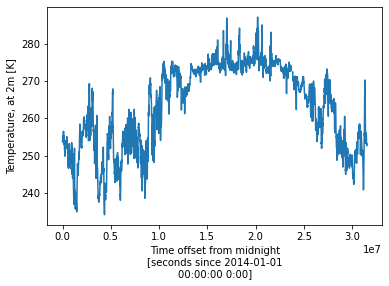

In [40]:
test_nc['temperature_sfc'].plot()

In [43]:
xr.decode_cf(test_nc)
# xr.decode_cf(test_nc['temperature_sfc'])

ValueError: unable to decode time units 'days since last day of the previous year' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [25]:
all_atmos = xr.open_mfdataset(atmos_files)

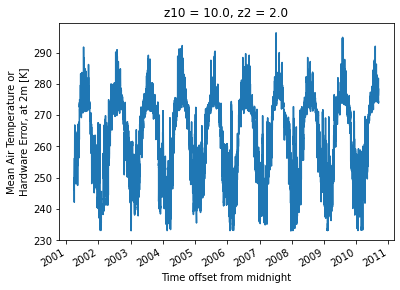

In [29]:
all_atmos['T_sfc'].plot()

In [19]:
test_arm = xr.open_dataset('%s/ATMOS/%s' % (arm_path,'nsaarmbeatmC1.c1.20010101.000000.custom.cdf'))

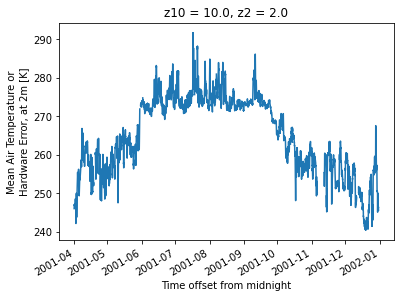

In [22]:
test_arm['T_sfc'].plot()

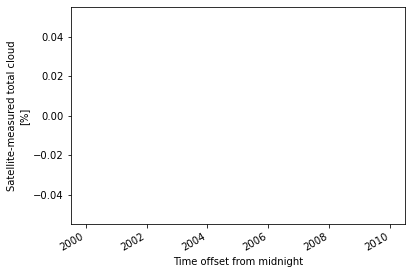

In [16]:
test_arm['cld_tot'].plot()

In [10]:
time_avg = test_arm['cld_tot'].groupby('time.month').mean('time')

In [11]:
time_avg

<xarray.DataArray 'cld_tot' (month: 12)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12